In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch


In [ ]:
# Load data
videos = pd.read_csv('october_videos.csv')
videos.head()

,Channel,Video ID,Title,Published,Views,Likes,Comments,Duration
0,ABC News,QWhBHJfVaN0,SNAP benefits set to run out due to government...,2025-10-31T23:00:40Z,52945,744,243,PT42S
1,ABC News,pHIbuFQapLc,The history behind daylight saving time,2025-10-31T21:26:21Z,27091,260,7,PT1M3S
2,ABC News,fOU8qXMoUaw,Blood visible from space in Sudan shows eviden...,2025-10-31T20:59:30Z,158978,2477,179,PT2M15S
3,ABC News,LnxWSjNeC4s,Blood visible from space in Sudan shows eviden...,2025-10-31T19:04:45Z,77483,511,343,PT3M19S
4,ABC News,NbwWV1yA--E,Judge rules Trump's attempt to suspend SNAP fu...,2025-10-31T18:34:49Z,674022,1788,2006,PT1M19S


In [ ]:
# Table max comments per channel
Channel_max_comment = videos.groupby("Channel")["Comments"].sum().sort_values(ascending=False)
Channel_max_comment

,Comments
Channel,
Fox News,83095
The Young Turks,81270
CNN,63630
The New York Times,36580
ABC News,29513
The Wall Street Journal,21701
CBS News,18589
NBC News,14333
USA Today,7670


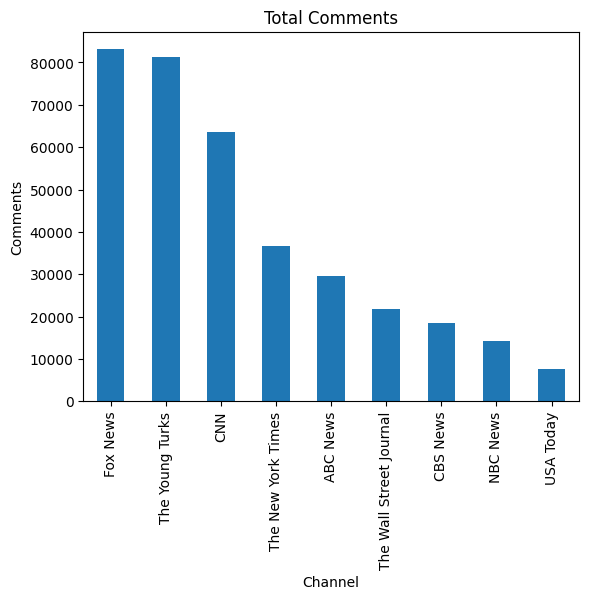

In [ ]:
# Plot max comment per channel
Channel_max_comment.plot(kind="bar")
plt.title("Total Comments")
plt.ylabel("Comments")
plt.show()

In [ ]:
# Load comment data
comments = pd.read_csv('october_video_comments.csv')
comments.head()


,video_id,comment_id,author,text,published_at,like_count
0,QWhBHJfVaN0,Ugz5kvme2I-rGiOkV254AaABAg,@user-kf5bz9xg3x,Money is there. It doesn't disappear taxes are...,2025-11-07T20:52:38Z,0
1,QWhBHJfVaN0,UgyLHfHINUz1_l9A5NB4AaABAg,@christinegoudy4155,"Impeach him, arrest him him, committ him!!",2025-11-06T11:05:31Z,0
2,QWhBHJfVaN0,UgzvztAJPFKFngjcfW54AaABAg,@jelly_fischer,"Ego, ego ego ego ego ego",2025-11-06T08:07:18Z,0
3,QWhBHJfVaN0,UgyPbz2PiyEtq1g9cdt4AaABAg,@anthonymargetson6829,It's not an emergency when it's done by choice...,2025-11-05T05:41:09Z,0
4,QWhBHJfVaN0,UgwK0amCKkV-sGUeArh4AaABAg,@jorge-l6q4w,The ballroom is funded privately why not ask D...,2025-11-05T01:38:39Z,0


In [ ]:
# Find top 10 related words in video comments
# Clean text
comments["text"] = comments["text"].fillna("")
texts = comments["text"].tolist()

# tfidf
vectorizer = TfidfVectorizer( # Initialize TF-IDF vectorizer with preprocessing parameters
    lowercase=True,
    stop_words="english",
    max_features=20000
)

tfidf_sparse = vectorizer.fit_transform(texts)

# sum tfidf for each word (still sparse)
word_scores = np.array(tfidf_sparse.sum(axis=0)).flatten()
feature_names = vectorizer.get_feature_names_out()

# Create df
top10_comments = pd.DataFrame({
    "word": feature_names,
    "score": word_scores
}).sort_values("score", ascending=False).head(10)

top10_comments

,word,score
17781,trump,6359.473968
12677,people,4540.653787
9626,just,3560.105870
10209,like,3489.249930
5403,don,3228.115936
4729,democrats,2831.568159
1006,america,2226.171863
13320,president,2174.514873
11578,need,2151.386178
7682,government,2124.017211


If I use only "october_video_comments.csv", trump appeared the most.
Next, let's see what happened if i analysis "title" and "text" together, but using bi-grams

In [ ]:
# Merge videos and comments by video_id, to analyze both "title" and "text" using bi-grams
videos = videos.rename(columns={"Video ID": "video_id"})
merged = comments.merge(videos, on="video_id", how="left")
merged.head()

,video_id,comment_id,author,text,published_at,like_count,Channel,Title,Published,Views,Likes,Comments,Duration
0,QWhBHJfVaN0,Ugz5kvme2I-rGiOkV254AaABAg,@user-kf5bz9xg3x,Money is there. It doesn't disappear taxes are...,2025-11-07T20:52:38Z,0,ABC News,SNAP benefits set to run out due to government...,2025-10-31T23:00:40Z,52945,744,243,PT42S
1,QWhBHJfVaN0,UgyLHfHINUz1_l9A5NB4AaABAg,@christinegoudy4155,"Impeach him, arrest him him, committ him!!",2025-11-06T11:05:31Z,0,ABC News,SNAP benefits set to run out due to government...,2025-10-31T23:00:40Z,52945,744,243,PT42S
2,QWhBHJfVaN0,UgzvztAJPFKFngjcfW54AaABAg,@jelly_fischer,"Ego, ego ego ego ego ego",2025-11-06T08:07:18Z,0,ABC News,SNAP benefits set to run out due to government...,2025-10-31T23:00:40Z,52945,744,243,PT42S
3,QWhBHJfVaN0,UgyPbz2PiyEtq1g9cdt4AaABAg,@anthonymargetson6829,It's not an emergency when it's done by choice...,2025-11-05T05:41:09Z,0,ABC News,SNAP benefits set to run out due to government...,2025-10-31T23:00:40Z,52945,744,243,PT42S
4,QWhBHJfVaN0,UgwK0amCKkV-sGUeArh4AaABAg,@jorge-l6q4w,The ballroom is funded privately why not ask D...,2025-11-05T01:38:39Z,0,ABC News,SNAP benefits set to run out due to government...,2025-10-31T23:00:40Z,52945,744,243,PT42S


In [ ]:
# Find out the top 10 related words by "title" and "text"

merged["title"] = merged["Title"].fillna("")
merged["text"] = merged["text"].fillna("")

merged["combined_text"] = merged["title"] + " " + merged["text"]
texts = merged["combined_text"].tolist()

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(2, 2),     # I think bigram will be better
)

count_mat = vectorizer.fit_transform(texts)

word_counts = np.array(count_mat.sum(axis=0)).flatten()
feature_names = vectorizer.get_feature_names_out()

word_freq_df = pd.DataFrame({
    "word": feature_names,
    "count": word_counts
})

top10_words = (
    word_freq_df
        .sort_values("count", ascending=False)
        .head(10)
)

top10_words


,word,count
939831,mike johnson,15625
616926,government shutdown,11745
1332721,snap benefits,8773
1592926,white house,8421
705363,ice agent,7047
478884,erika kirk,6260
1006186,nuclear weapons,6080
1024022,old man,5891
1006143,nuclear testing,5720
1641672,yr old,5631


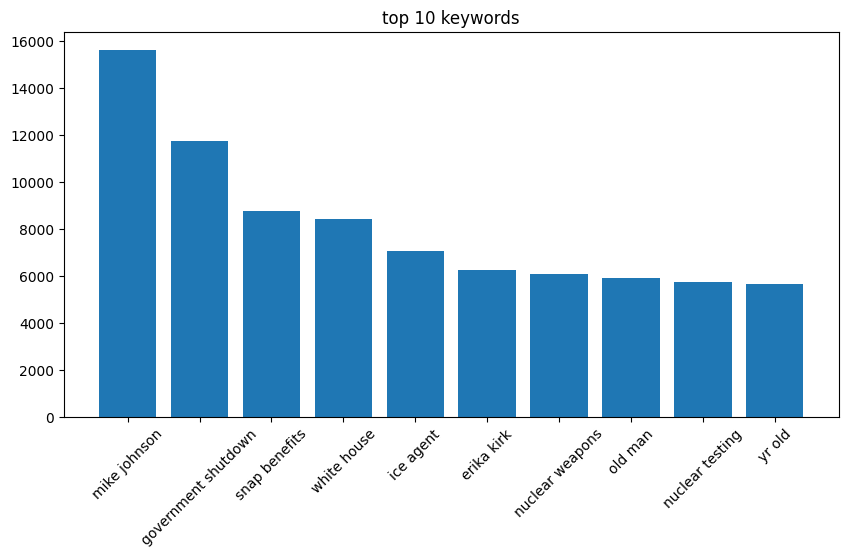

In [ ]:
# Plot the top 10 keywords

plt.figure(figsize=(10,5))
plt.bar(top10_words["word"], top10_words["count"])
plt.title("top 10 keywords")
plt.xticks(rotation=45)
plt.show()

Here, mike johnson became the top searching word. More events have been discovered such as the government shutdown because parties argue over the SNAP benefits in the white house. And "ICE agent" reveals the actions regards to undocuments immigration, " Erika Kirk" is related to Charlie Kirk's assessment.

In [ ]:
# Hugging face for sentiment analysis
sentiment = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [ ]:
# Select model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Use fast tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move model to GPU if cuda-compatible GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Prepare dataset
texts = merged["text"].fillna("").tolist()

# Use Batching to define robust for sentiment
def sentiment_batch(text_list, batch_size=64):
    sentiments = []

    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]

        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=64,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            output = model(**encoded)

        batch_scores = output.logits.argmax(dim=1).cpu().numpy()
        sentiments.extend(batch_scores)

    return sentiments

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
# Run sentiment
sentiment_results = sentiment_batch(texts, batch_size=64)

In [ ]:
# Convert numbers to labels
label_map = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
merged["sentiment"] = [label_map[x] for x in sentiment_results]

In [ ]:
# Count the total number of NEG, POS, NEU
merged["sentiment"].value_counts()

,count
sentiment,
NEGATIVE,184635
NEUTRAL,74910
POSITIVE,34303


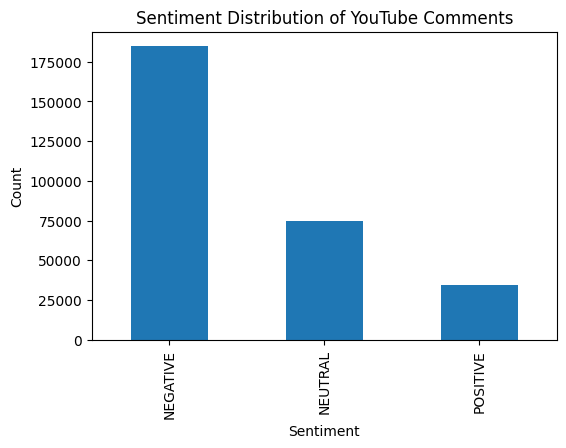

In [ ]:
# Plot sentiment distribution for Youtube comments

merged["sentiment"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("Sentiment Distribution of YouTube Comments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:
# Aggregate sentiments per channel
sentiment_by_channel = (
    merged.groupby(["Channel", "sentiment"])
          .size()
          .reset_index(name="count")
)

# Convert into pivot table
pivot_table = sentiment_by_channel.pivot(
    index="Channel",
    columns="sentiment",
    values="count"
).fillna(0)

pivot_table

sentiment,NEGATIVE,NEUTRAL,POSITIVE
Channel,,,
ABC News,14715,6169,3166
CBS News,9172,4797,1704
CNN,31128,12343,4587
Fox News,39503,16955,9579
NBC News,6413,4151,2063
The New York Times,16525,7062,3795
The Wall Street Journal,8268,6937,2464
The Young Turks,55582,14642,5876
USA Today,3329,1854,1069


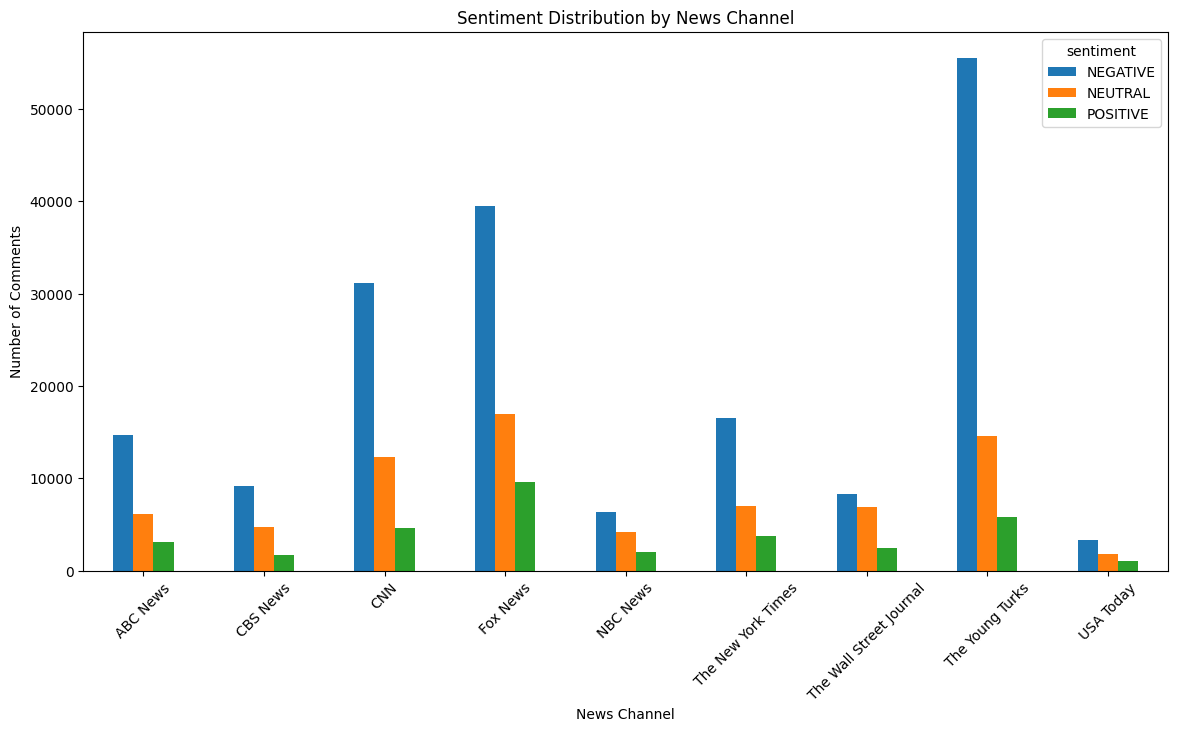

In [ ]:
# Graph aggregate sentiments per channel
pivot_table.plot(
    kind="bar",
    figsize=(14,7),
    ylabel="Number of Comments",
    xlabel="News Channel",
    title="Sentiment Distribution by News Channel",
)

plt.xticks(rotation=45)
plt.show()

In [ ]:
# Average channel emotion by max sentiment
max_sentiment = pivot_table.idxmax(axis=1)
max_sentiment

,0
Channel,
ABC News,NEGATIVE
CBS News,NEGATIVE
CNN,NEGATIVE
Fox News,NEGATIVE
NBC News,NEGATIVE
The New York Times,NEGATIVE
The Wall Street Journal,NEGATIVE
The Young Turks,NEGATIVE
USA Today,NEGATIVE
